# Imports and Setup

In [4]:
# Imports
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageOps
from keras.utils import load_img
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from data_set import load_file_paths, get_datasets

# Ensure dataset folder exists
os.makedirs("dataset", exist_ok=True)

# Global parameters
input_dir = "dataset/images/"
target_dir = "dataset/annotations/trimaps/"
img_size = (160, 160)
batch_size = 32
num_classes = 3
val_samples = 1000


# Download and Extract Dataset

In [5]:
# Download and extract the Oxford Pets dataset
!wget -P dataset https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget -P dataset https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

!tar -xf dataset/images.tar.gz -C dataset
!tar -xf dataset/annotations.tar.gz -C dataset

print("Dataset downloaded and extracted successfully.")


--2024-12-30 20:13:57--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2024-12-30 20:13:58--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘dataset/images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  21.5MB/s    in 37s     

2024-12-30 20:14:37 (20.2 MB/s) - ‘dataset/images.tar.gz’ saved [791918971/791918971]

--2024-12-30 20:14:37--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

# Improviserar

Number of input images: 7390
Number of target masks: 7390
First 5 samples:
dataset/images/Abyssinian_1.jpg | dataset/annotations/trimaps/Abyssinian_1.png
dataset/images/Abyssinian_10.jpg | dataset/annotations/trimaps/Abyssinian_10.png
dataset/images/Abyssinian_100.jpg | dataset/annotations/trimaps/Abyssinian_100.png
dataset/images/Abyssinian_101.jpg | dataset/annotations/trimaps/Abyssinian_101.png
dataset/images/Abyssinian_102.jpg | dataset/annotations/trimaps/Abyssinian_102.png
Training samples: 5912
Validation samples: 1478
Epoch 1/23
370/370 ━━━━━━━━━━━━━━━━━━━━ 99s 186ms/step - accuracy: 0.5626 - loss: 1.2224 - val_accuracy: 0.5855 - val_loss: 4.7930 - learning_rate: 1.0000e-04
Epoch 2/23
370/370 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.6570 - loss: 0.7478 - val_accuracy: 0.7062 - val_loss: 0.7403 - learning_rate: 1.0000e-04
Epoch 3/23
370/370 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.6844 - loss: 0.6893 - val_accuracy: 0.7302 - val_loss: 0.7227 - learning_rate: 1.00

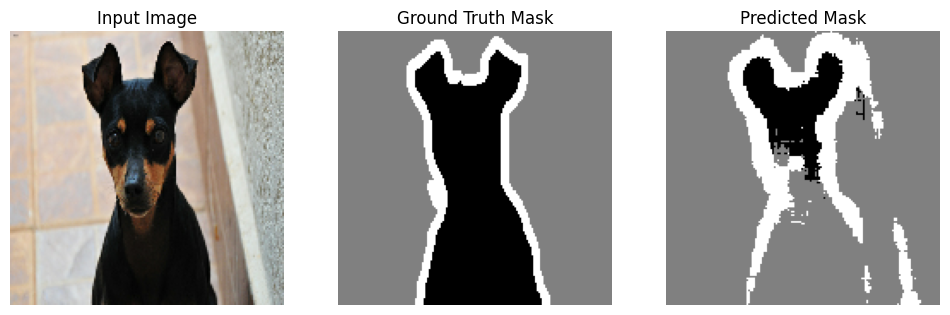

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8059 - loss: 0.5387
Validation Loss: 0.5397
Validation Accuracy: 0.8052


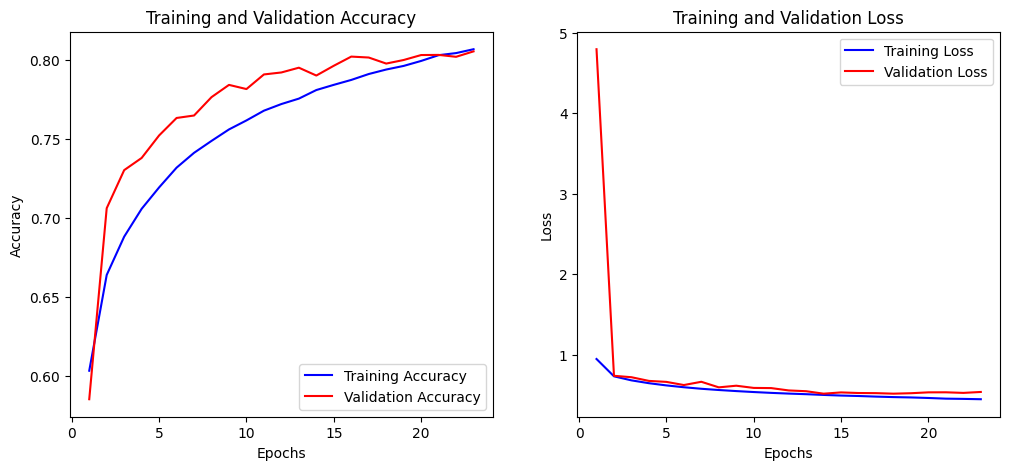

In [6]:
import os
from data_set import get_datasets, preprocess_image_mask
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import io as tf_io
import data_set
import importlib
importlib.reload(data_set)
from tensorflow.keras import backend as K

input_dir = "dataset/images/"
target_dir = "dataset/annotations/trimaps/"
batch_size = 16
img_size = (160, 160)

# Debug datasets
train_dataset, val_dataset = get_datasets(input_dir, target_dir, batch_size, img_size=img_size)

# Data augmentation
def augment_data(image, mask):
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random brightness adjustment
    if tf.random.uniform(()) > 0.5:
        image = tf.image.adjust_brightness(image, delta=0.2)

    # Random contrast adjustment
    if tf.random.uniform(()) > 0.5:
        image = tf.image.adjust_contrast(image, contrast_factor=0.8)

    # Random rotation
    if tf.random.uniform(()) > 0.5:
        image = tf.image.rot90(image)
        mask = tf.image.rot90(mask)

    # Random gussian noise
    if tf.random.uniform(()) > 0.5:
      noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=tf.float32)
      image = tf.clip_by_value(image + noise, 0.0, 1.0)

    return image, mask

train_dataset = train_dataset.map(
    lambda x, y: augment_data(x, y),
    num_parallel_calls=tf.data.AUTOTUNE
)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Define U-Net-like model
def get_unet_model(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size + (3,))

    # Downsampling
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x

    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        if filters == 256:  # Only apply dropout to the deepest layer
          x = layers.Dropout(0.2)(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    # Upsampling
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.UpSampling2D(2)(x)
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])
        previous_block_activation = x

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    return Model(inputs, outputs)

# Load the model
model = get_unet_model(img_size, num_classes)

# Class weights
class_weights = {0: 1.0, 1: 0.5, 2: 2.5}

def weighted_sparse_categorical_crossentropy(class_weights):
    def loss(y_true, y_pred):
        y_true = K.cast(tf.squeeze(y_true, axis=-1), 'int32')
        weights = tf.gather(tf.constant(list(class_weights.values())), y_true)
        scce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        return K.mean(weights * scce)
    return loss

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    #loss= "sparse_categorical_crossentropy",
    loss=weighted_sparse_categorical_crossentropy(class_weights),
    metrics=['accuracy']
)

def scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * 0.95

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(
    train_dataset,
    epochs=23,
    validation_data=val_dataset,
    callbacks=[lr_callback]
)

for img, mask in val_dataset.take(1):
    pred_mask = model.predict(img)
    pred_mask_class = tf.argmax(pred_mask, axis=-1).numpy()

    # Visualize the first image and its predicted mask
    plt.figure(figsize=(12, 4))

    # Input image
    plt.subplot(1, 3, 1)
    plt.imshow(tf.squeeze(img[0]).numpy())
    plt.title("Input Image")
    plt.axis("off")

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(tf.squeeze(mask[0]).numpy(), cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask_class[0], cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

#history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)

# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_dataset)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Plot accuracy and loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the plotting function
plot_history(history)